<img src='https://drive.google.com/uc?export=view&id=12B8SAPMBgZIcRKLsuR2CayCLxwa6XbK2' width="70">

# Project Setup

Mount Google Drive file system so that later we can read/write data from/to it.

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)
!df -h /content/drive

Mounted at /content/drive
Filesystem      Size  Used Avail Use% Mounted on
drive            79G   29G   50G  38% /content/drive


In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# # Use GPU instead of CPU
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/IA-Project4"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Load CIFAR-10 Dataset

We'll begin by loading the CIFAR-10 dataset, which is readily accessible through the keras.datasets module in Keras. This module provides various functions to load well-known datasets. The CIFAR-10 dataset comes pre-divided into training and test sets.

In [ ]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

The training set contains 50,000 in-color images, each 32x32 pixels:

In [ ]:
print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

print(type(X_train_full))
print(X_train_full[0])

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
<class 'numpy.ndarray'>
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


Each pixel intensity is represented as a byte (0 to 255):

We split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255, X_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255
X_test[0,7]

array([[0.51372549, 0.45098039, 0.35294118],
       [0.38823529, 0.37647059, 0.36078431],
       [0.16470588, 0.16862745, 0.14901961],
       [0.2745098 , 0.25098039, 0.16078431],
       [0.56078431, 0.43529412, 0.21960784],
       [0.65490196, 0.45882353, 0.16470588],
       [0.64705882, 0.44705882, 0.14117647],
       [0.65882353, 0.45490196, 0.15294118],
       [0.67058824, 0.46666667, 0.19215686],
       [0.63137255, 0.44313725, 0.2       ],
       [0.54901961, 0.42745098, 0.2       ],
       [0.47058824, 0.36862745, 0.19215686],
       [0.50980392, 0.43137255, 0.30196078],
       [0.56470588, 0.51372549, 0.41960784],
       [0.45490196, 0.41568627, 0.36470588],
       [0.34509804, 0.34117647, 0.30980392],
       [0.35686275, 0.37254902, 0.34509804],
       [0.33333333, 0.34509804, 0.32156863],
       [0.30196078, 0.30196078, 0.27058824],
       [0.48627451, 0.4627451 , 0.41960784],
       [0.63921569, 0.6       , 0.54901961],
       [0.53333333, 0.48627451, 0.43921569],
       [0.

We can plot an image using Matplotlib's `imshow()` function, with the
 color map of an example of the dataset we are using:

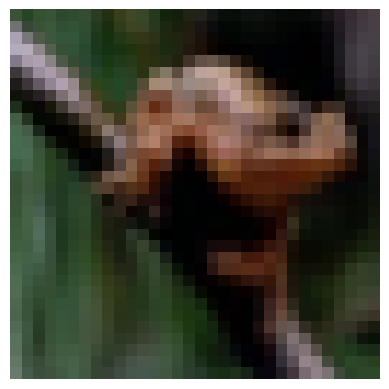

In [ ]:
plt.imshow(X_train[0])
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train

array([[6],
       [7],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Here are the corresponding class names:

In [ ]:
# CIFAR-10 class names
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

So the first image in the training set is a frog:

In [ ]:
# Since the labels in CIFAR-10 are stored in arrays (even if each array only contains one integer), we need to access the first element of y_train[0] when referencing the class names.
class_names[y_train[0][0]]

'frog'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

(5000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

Let's take a look at a sample of the images in the dataset:

Saving figure cifar10_plot


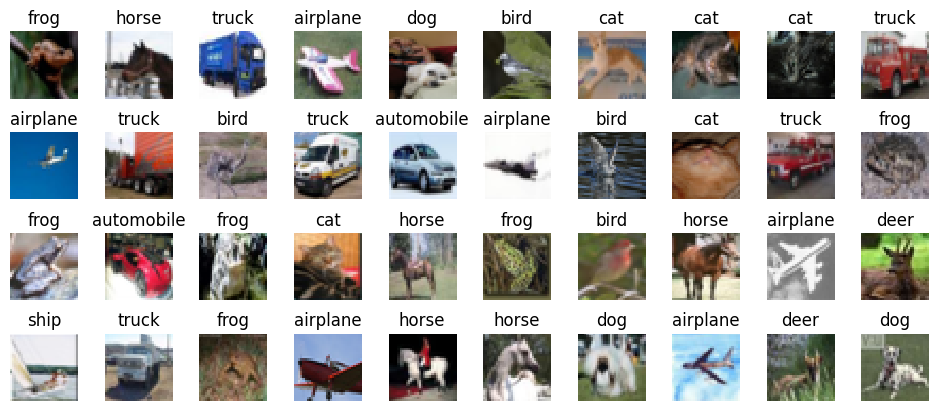

In [ ]:
# Adjusted to show the dataset images
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('cifar10_plot', tight_layout=False)
plt.show()

# Build and Train the Different Neural Network Models

This will serve as our **baseline** model, setting a benchmark for the minimum performance expected from all subsequent models. It also provides a base for further analysis and enhancement.

An optimal starting point involves adopting the fundamental architectural principles of the VGG models.

This architecture entails the sequential arrangement of convolutional layers featuring 3×3 filters, followed by a max-pooling layer. These layers are organized into blocks, which can be replicated, with an increase in the number of filters per block as the network deepens, typically starting at 32, 64, 128, and 256 for the initial four blocks. To maintain consistency in feature map dimensions, padding is applied to the convolutional layers.

We can experiment with this architecture using the CIFAR-10 dataset and assess models with 1, 2, 3, and 4 blocks for performance comparison.

In [ ]:
"""
# Build a 1-block vgg style architecture convolutional neural network model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
"""

"\n# Build a 1-block vgg style architecture convolutional neural network model\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\n"

In [ ]:
"""
# Build a 2-block vgg style architecture convolutional neural network model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
"""

"\n# Build a 2-block vgg style architecture convolutional neural network model\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\n"

In [ ]:
"""
# Build a 3-block vgg style architecture convolutional neural network model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
"""

"\n# Build a 3-block vgg style architecture convolutional neural network model\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\n"

In [ ]:
"""
# Build a 4-block vgg style architecture convolutional neural network model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
"""

"\n# Build a 4-block vgg style architecture convolutional neural network model\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\n"

Having established a baseline model utilizing the VGG architecture with four blocks, we are now set to test adjustments to both the model and training algorithm, aiming to improve the performance.

**Dropout**
Dropout is a straightforward technique that randomly omits nodes from the network, fostering regularization as the remaining nodes adjust to compensate for the removed ones.

To implement Dropout, additional Dropout layers are introduced into the model, with the extent of node removal specified as a parameter.

For this project, we'll integrate Dropout layers following each max-pooling layer and the fully connected layer, employing a consistent dropout rate of 20% (retaining 80% of the nodes).

Here's the updated VGG 4 baseline model with Dropout:

In [ ]:
"""
# Build a 4-block vgg convolutional neural network model adding dropout layers
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
"""

"\n# Build a 4-block vgg convolutional neural network model adding dropout layers\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Dropout(0.2))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Dropout(0.2))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Dropout(0.2))\nmodel.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))\nmodel.add(keras.layers.Conv2D(256, (3, 3), activa

**Weight Regularization**
Incorporating weight regularization adjusts the loss function by imposing a penalty based on the magnitude of the model's weights.

This produces a stabilizing effect, since heavy weights can lead to a model that is overly complex and unstable, whereas lighter weights tend to a more robust and generalized model.

To implement it to our convolutional and fully connected layers, we establish the "kernel_regularizer" parameter and define the chosen regularization type. Here we will employ L2 weight regularization, which is the standard approach for neural networks, with a regularization factor of 0.0001.

In [ ]:
"""
# Build a 4-block vgg convolutional neural network model adding weight regularization
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
"""

"\n# Build a 4-block vgg convolutional neural network model adding weight regularization\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), input_shape=(32, 32, 3)))\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))\nmodel.add(keras.layers.MaxPooling2D((2, 2)))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))\nmodel.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regulariz

Finally, the following would be our most refined iteration, a significant improvement over our baseline model. Leveraging a 4-block VGG convolutional neural network architecture, we have augmented its performance by integrating dropout layers and weight regularization techniques.

In [ ]:

# Build a 4-block vgg convolutional neural network model adding dropout layers and weight regularization
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))


We have provided above the different models to test. However, each of them needs complementation with a classifier component that discerns these features and generates predictions regarding the class to which a given photo pertains.

Below, we have standarized this process across all models. The output layer must comprise 10 nodes corresponding to the 10 classes, utilizing the softmax activation function.

In [ ]:
# Output part of the model
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

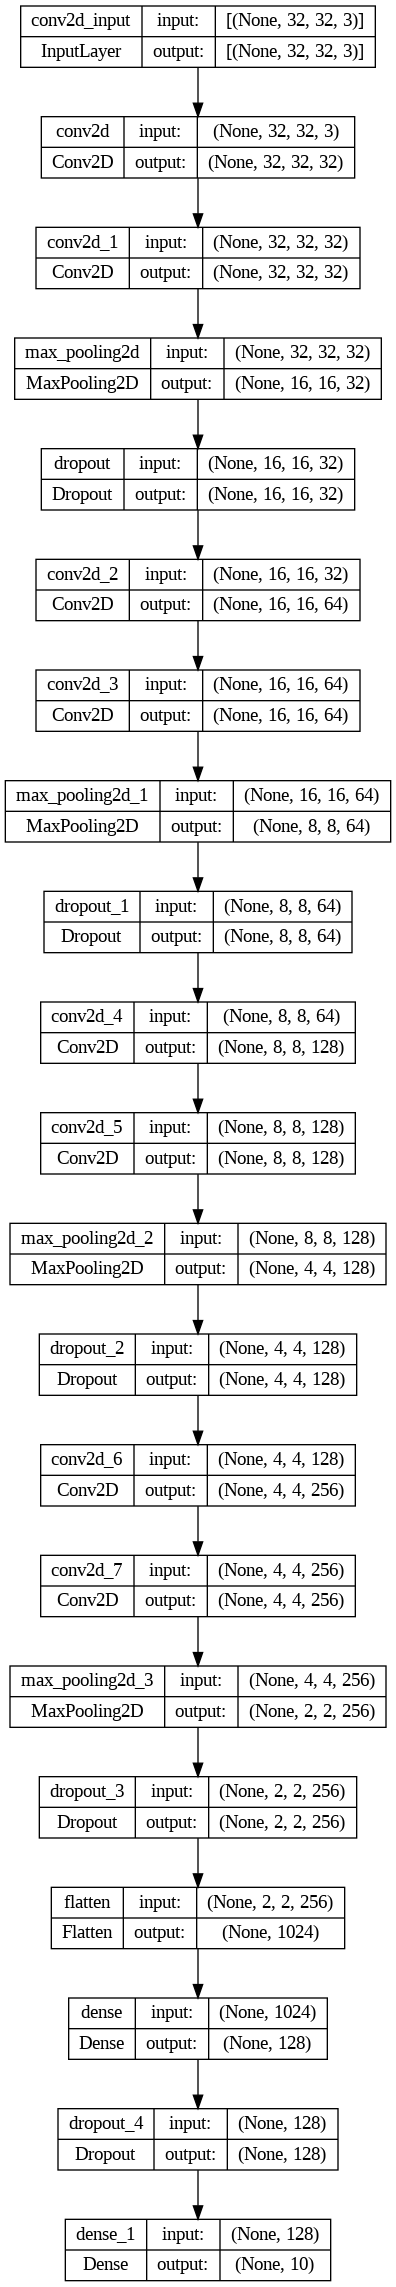

In [ ]:
keras.utils.plot_model(model, IMAGES_PATH+"/my_cifar10_model.png", show_shapes=True)

In [ ]:
hidden1 = model.layers[1]
hidden1.name

'conv2d_1'

In [ ]:
model.get_layer(hidden1.name) is hidden1

True

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

array([[[[ 0.03544274,  0.0462238 , -0.04913358, ...,  0.00822725,
          -0.04070371,  0.01373516],
         [ 0.07604852,  0.00836544,  0.08949275, ...,  0.00586647,
           0.02647759, -0.08229887],
         [ 0.06205361,  0.04527274, -0.09422837, ...,  0.02306643,
           0.07095255,  0.02750957],
         ...,
         [-0.01269036,  0.0886438 ,  0.07254535, ...,  0.02719153,
          -0.09574773, -0.0294919 ],
         [-0.03264774, -0.08669733,  0.07545006, ..., -0.06116093,
           0.05047651, -0.00478112],
         [ 0.01011638, -0.09204227,  0.09982891, ...,  0.08815271,
          -0.02196529, -0.06722588]],

        [[ 0.05730519, -0.09581487,  0.05459023, ...,  0.03344697,
           0.05395339, -0.06171653],
         [ 0.08008766, -0.0501708 , -0.0119888 , ..., -0.01681399,
          -0.04314487, -0.03346043],
         [ 0.04536447,  0.0268203 , -0.0906347 , ...,  0.05873042,
           0.0632593 ,  0.06492856],
         ...,
         [-0.0433079 ,  0.00772785

In [ ]:
weights.shape

(3, 3, 32, 32)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
biases.shape

(32,)

We will optimize the model using stochastic gradient descent.

We will use a modest learning rate of 0.001 and a large momentum of 0.9, both of which are good general starting points. The model will optimize the sparse categorical crossentropy loss function required for multi-class classification and will monitor classification accuracy.

In [ ]:
# Compile the model
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
# below we can see, for each epoch, a progress bar for 1719 batches, each batch
# is of size 32.  Batch size is 32 by default. We can use a different
# batch size, say, 60, seting batch_size=60 inside fit call.

Epoch 1/10
1407/1407 [==============================] - 14s 8ms/step - loss: 2.1286 - accuracy: 0.2312 - val_loss: 1.8070 - val_accuracy: 0.3592
Epoch 2/10
1407/1407 [==============================] - 11s 8ms/step - loss: 1.6818 - accuracy: 0.4089 - val_loss: 1.4599 - val_accuracy: 0.4948
Epoch 3/10
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4309 - accuracy: 0.5102 - val_loss: 1.2392 - val_accuracy: 0.5874
Epoch 4/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.2432 - accuracy: 0.5885 - val_loss: 1.1453 - val_accuracy: 0.6336
Epoch 5/10
1407/1407 [==============================] - 11s 8ms/step - loss: 1.1195 - accuracy: 0.6426 - val_loss: 0.9883 - val_accuracy: 0.6948
Epoch 6/10
1407/1407 [==============================] - 11s 8ms/step - loss: 1.0100 - accuracy: 0.6852 - val_loss: 0.9938 - val_accuracy: 0.6954
Epoch 7/10
1407/1407 [==============================] - 11s 7ms/step - loss: 0.9454 - accuracy: 0.7120 - val_loss: 0.8992 - val_ac

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 1407}

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


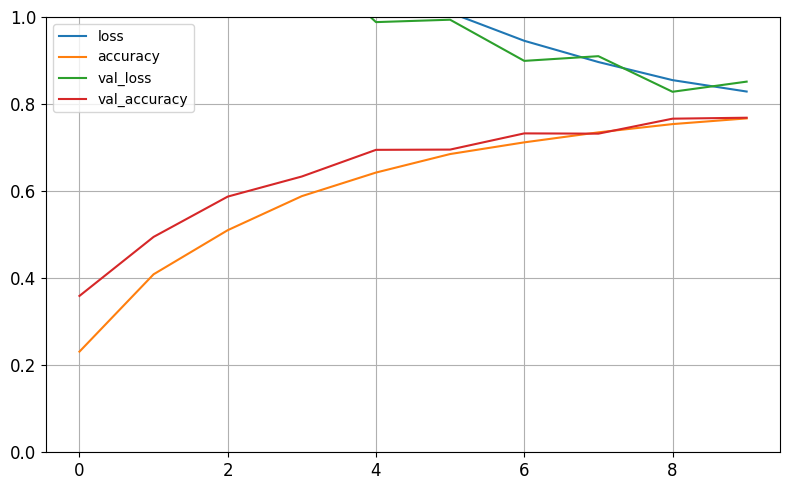

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

# Evaluate and Predict

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.8721 - accuracy: 0.7592


[0.8721305727958679, 0.7591999769210815]

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 174ms/step


array([[0.  , 0.  , 0.  , 0.89, 0.  , 0.08, 0.03, 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  ],
       [0.13, 0.05, 0.03, 0.05, 0.02, 0.01, 0.02, 0.01, 0.6 , 0.09]],
      dtype=float32)

In [ ]:
y_pred = (model.predict(X_new) > 0.5).astype("int32")

y_pred

1/1 [==============================] - 0s 24ms/step


array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [ ]:
np.array(class_names)[y_pred]

array([['airplane', 'airplane', 'airplane', 'automobile', 'airplane',
        'airplane', 'airplane', 'airplane', 'airplane', 'airplane'],
       ['airplane', 'airplane', 'airplane', 'airplane', 'airplane',
        'airplane', 'airplane', 'airplane', 'automobile', 'airplane'],
       ['airplane', 'airplane', 'airplane', 'airplane', 'airplane',
        'airplane', 'airplane', 'airplane', 'automobile', 'airplane']],
      dtype='<U10')

In [ ]:
y_new = y_test[:3]
y_new

array([[3],
       [8],
       [8]], dtype=uint8)

Saving figure cifar10_images_plot


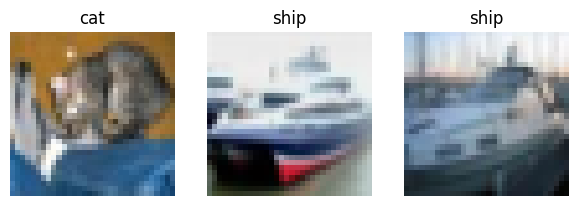

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('cifar10_images_plot', tight_layout=False)
plt.show()

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
